# Cluster points along a spatial network

Cluster a set of fake firms based on their network distances from each other.

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import time
from scipy.sparse import csr_matrix
from scipy.spatial.distance import squareform, pdist
from sklearn.cluster import DBSCAN

ox.config(use_cache=True, log_console=True)

In [2]:
# parameterize DBSCAN
eps = 300 #meters
minpts = 10 #smallest cluster size allowed
pseudo_minpts = 1 #we're clustering nodes, not firms, so throw nothing away as noise: a single node might be alone,
                  #but may contain a hundred points as they're nearest node.

# fake data: create n_firms evenly disbursed across n_clusters
n_firms = 1e6
n_clusters = 10

place = 'Oakland, California, USA'

## Create the street network

In [3]:
# get the street network
G = ox.graph_from_place(place, network_type='drive')
G = ox.get_largest_component(G, strongly=True)

In [4]:
print(len(G.nodes))
print(len(G.edges))

8271
22072


## Create a fake set of firms

In [5]:
# randomly select n_clusters number of nodes from the graph
np.random.seed(7)
firm_centers = np.random.choice(G.nodes(), size=n_clusters, replace=False)

In [6]:
# scatter some firms around the selected nodes
xs = []
ys = []
for osmid in firm_centers:
    x = G.node[osmid]['x']
    y = G.node[osmid]['y']
    np.random.seed(1)
    xs.extend(np.random.normal(loc=x, scale=0.001, size=int(n_firms/len(firm_centers))))
    ys.extend(np.random.normal(loc=y, scale=0.001, size=int(n_firms/len(firm_centers))))
    
firms = pd.DataFrame({'x':xs, 'y':ys})
len(firms)

1000000

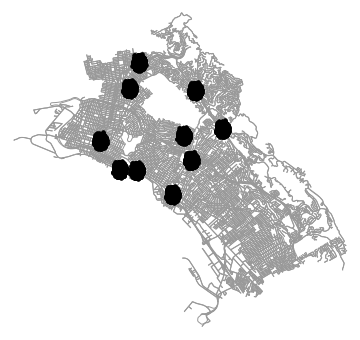

In [7]:
# plot the firms and the points around which they cluster
ns = 0#[100 if n in centers else 0 for n in G.nodes()]
fig, ax = ox.plot_graph(G, node_color='#aaaaaa', node_size=ns, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c='k', marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

## Attach nearest node to each firm then make network-based distance matrix

Speed up distance matrix computation: rather than calculating every firm to every firm, find every node with at least 1 firm attached, then calculate every such node to every such node distance. Once we have the node-to-node distances, reindex it to make use those distances firm-to-firm.

In [8]:
start_time = time.time()

In [9]:
%%time
# attach nearest network node to each firm
firms['nn'] = ox.get_nearest_nodes(G, X=pd.Series(xs), Y=pd.Series(ys), method='kdtree')
print(len(firms['nn']))

1000000
Wall time: 1.41 s


In [10]:
# we'll get distances for each pair of nodes that have firms attached to them
nodes_unique = pd.Series(firms['nn'].unique())
nodes_unique.index = nodes_unique.values
print(len(nodes_unique))

549


In [11]:
# convert MultiDiGraph to DiGraph for simpler faster distance matrix computation
G_dm = nx.DiGraph(G)

In [12]:
# create a euclidean distance vector between the nodes to quickly find nearby nodes within some distance threshold
x = nodes_unique.map(lambda x: G.node[x]['x'])
y = nodes_unique.map(lambda x: G.node[x]['y'])
df = pd.DataFrame({'x':x, 'y':y}, index=nodes_unique)
dist_matrix = squareform(pdist(X=df, metric='euclidean'))
df_dist_matrix = pd.DataFrame(data=dist_matrix, columns=df.index.values, index=df.index.values)
node_euclidean_dists = df_dist_matrix.stack()

In [13]:
# calculate network-based distance between each node
def network_distance_matrix(u, G, node_euclidean_dists=node_euclidean_dists):
    
    # only calculate distances between u and nodes within 0.005 degrees (ie, ~400 m) of it
    nearby_nodes = node_euclidean_dists[u][node_euclidean_dists[u] < 0.005].index
    
    # calculate network distances
    net_dists = [nx.dijkstra_path_length(G, source=u, target=v, weight='length') for v in nearby_nodes]
    
    # for all nodes beyond "nearby" cut-off, make distance anything larger than epsilon
    return pd.Series(data=net_dists, index=nearby_nodes).reindex(nodes_unique).fillna(eps+1).astype(int)

In [14]:
%%time
# create node-based distance matrix called node_dm
node_dm = nodes_unique.apply(network_distance_matrix, G=G_dm)
node_dm = node_dm.astype(int)
print(node_dm.size)

301401
Wall time: 6.12 s


## Make distance matrix sparse

In a regular distance matrix, zero elements are considered neighbors (they're on top of each other). With a sparse matrix only nonzero elements may be considered neighbors for DBSCAN. First, make all zeros a very small number instead, so we don't ignore them. Otherwise, we wouldn't consider two firms attached to the same node as cluster neighbors. Then set everything bigger than epsilon to 0, so we do ignore it as we won't consider them neighbors anyway.

In [15]:
node_dm[node_dm == 0] = 1
node_dm[node_dm > eps] = 0

In [16]:
# how much space does the dense matrix use, in MB?
dense_size = node_dm.as_matrix().nbytes / 1e6
dense_size

1.205604

In [17]:
%%time
# convert network-based distance matrix to a sparse matrix
node_dm = csr_matrix(node_dm)

Wall time: 4 ms


In [18]:
# how much space does the sparse matrix use, in MB?
sparse_size = (node_dm.data.nbytes + node_dm.indptr.nbytes + node_dm.indices.nbytes) / 1e6
sparse_size

0.046944

## Cluster firms along the network

Use the sparse network-based distance matrix to compute DBSCAN (converges much faster and uses much less memory than using the dense matrix with a big data set).

In [19]:
%%time
# use metric=precomputed to fit model to the sparse network-based distance matrix
db = DBSCAN(eps=eps, min_samples=pseudo_minpts, metric='precomputed')
cluster_labels = db.fit_predict(node_dm)

Wall time: 3.99 ms


In [20]:
# map each firm's nearest-node to the node cluster labels
node_clusters = {node:label for node, label in zip(nodes_unique.index, cluster_labels)}
firms['network_cluster'] = firms['nn'].map(lambda x: node_clusters[x])
len(firms['network_cluster'].unique())

55

In [21]:
firms['network_cluster'].value_counts().tail()

13    2
39    2
19    1
28    1
27    1
Name: network_cluster, dtype: int64

In [22]:
# turn any clusters with fewer than minpts elements into noise
vc = firms['network_cluster'].value_counts()
noise_labels = vc.index[vc < minpts]
row_idx = firms['network_cluster'].isin(noise_labels)
firms.loc[row_idx, 'network_cluster'] = -1

In [23]:
firms['network_cluster'].value_counts().tail()

35    19
18    14
17    14
34    14
44    10
Name: network_cluster, dtype: int64

In [24]:
# total execution time
round(time.time() - start_time, 2)

8.52

## Plot the final network-based clusters, then save to disk

In [25]:
# get point colors by cluster
unique_labels = firms['network_cluster'].unique()
colors = ox.get_colors(n=len(unique_labels), cmap='hsv', return_hex=True)
color_map = {label:color for label, color in zip(unique_labels, colors)}
point_colors = [color_map[c] for c in firms['network_cluster']]

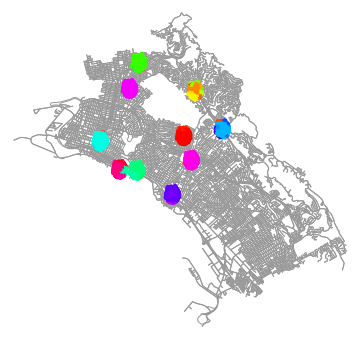

In [26]:
# plot firms by cluster
fig, ax = ox.plot_graph(G, node_color='gray', node_size=0, show=False, close=True)
ax.scatter(x=firms['x'], y=firms['y'], c=point_colors, marker='.', s=50, zorder=3)
fig.canvas.draw()
fig

In [27]:
# save the graph to disk
ox.save_graph_shapefile(G, folder='data')

In [28]:
# save and show the clustered firms data set
firms = firms.reindex(columns=['x', 'y', 'nn', 'network_cluster'])
firms.to_csv('data/clustered-by-node.csv', encoding='utf-8', index=False)
firms[10:15]

,x,y,nn,network_cluster
10,-122.221373,37.809896,53137353,0
11,-122.224895,37.807517,390568598,0
12,-122.223157,37.807422,53050199,0
13,-122.223219,37.807817,53050199,0
14,-122.221701,37.808353,683790646,0
